In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

%matplotlib inline

In [2]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Functions for later use

In [274]:
def accuracy_confusion_mat(model, x_test, y_test, y_predicted):
    acc_score = model.score(x_test, y_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    
    total = np.sum(confusion_matrix)
    
    print('Total number of observations = ', total)
    print('Accuracy = ', round(acc_score, 2))
    
    #print('\nConfusion Matrix:\n', confusion_matrix)

    return acc_score, confusion_matrix

In [275]:
def confusion_plt(confusion_matrix, acc_score):
    plt.figure( figsize = (3, 3))
    sns.heatmap(confusion_matrix, annot = True, fmt=".3f", linewidths = .5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    acc_score = round(acc_score, 2)

    all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
    plt.title(all_sample_title, size = 13)

In [276]:
def confusion_perc_plt(confusion_matrix, acc_score):
    total = np.sum(confusion_mat)
    perc_confusion_matrix = confusion_mat/total
    
    plt.figure( figsize = (3, 3))
    sns.heatmap(perc_confusion_matrix, annot = True, fmt=".3f", linewidths = .5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    acc_score = round(acc_score, 2)

    all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
    plt.title(all_sample_title, size = 13)
    
    return total

In [277]:
def errors(confusion_matrix):
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    print('\nTP =', TP, '\nTN =', TN, '\nFP =', FP, '\nFN =', FN)
        
    return TP, TN, FP, FN

In [278]:
def precision_recall(TP, TN, FP, FN):
    really_survived = TP + FN
    diagnosed_as_survived = TP + FP

    # among all cases that were found positive, what a % of actual positive cases
    precision = round(TP/diagnosed_as_survived, 2)
    # percentage of the people who indeed survived out of all cases that the model classified as 'survived' 
    # ex., % of really sick people that the test diagnosted as sick. 
    # if you were diagnosted as ill, what is the chance that you are really ill

    # percentage of correctly diagnosted people
    recall = round(TP/really_survived, 2)
    
    print('\nPrecision =', precision , '\nRecall =', recall)
    
    return precision, recall

#### Import the Data

In [3]:
data = pd.read_csv('C:\\Users\\Inna\\Desktop\\scripts\\Titanic\\train.csv', index_col=0)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
# pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
# sibsp 	# of siblings / spouses aboard the Titanic
# parch 	# of parents / children aboard the Titanic

In [6]:
print('The dataset provides Titanic passengers’ information. It includes', data.shape[0], 
      'records and', data.shape[1], 'features')

The dataset provides Titanic passengers’ information. It includes 891 records and 11 features


In [7]:
print('The list of the features:', list(data.columns))

The list of the features: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


### Creating Dummy Variables 

#### Create dummy variables for sex (1 = female, 0 = male) and the port of embarktion (1 = C = Cherbourg, 2 = Q = Queenstown, 3 = S = Southampton)

In [8]:
data['Sex_num'] = data.Sex.map({'female':1, 'male':0})
# data['Embarked_num'] = data.Embarked.map({'C':1, 'Q':2, 'S':3})

In [9]:
# One-hot vectors for the port of emabarking: 
# 1. create vectors of zeros: 
data_len = len(data['Name'])
data['Cherbourg'] = pd.Series(np.zeros(data_len), index = data.index)
data['Queenstown'] = pd.Series(np.zeros(data_len), index = data.index)
data['Southampton'] = pd.Series(np.zeros(data_len), index = data.index)

# 2. encode the data into these vectors acording to the port of embarktion: 
data['Cherbourg'] = data['Cherbourg'].where(data['Embarked'] != 'C', 1)
data['Queenstown'] = data['Queenstown'].where(data['Embarked'] != 'Q', 1)
data['Southampton'] = data['Southampton'].where(data['Embarked'] != 'S', 1)

In [10]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0.0,0.0,1.0


In [11]:
print('The updated dataset provides Titanic passengers’ information. It includes', data.shape[0], 
      'records and', data.shape[1], 'features')
print('The updated list of the features:', list(data.columns))

The updated dataset provides Titanic passengers’ information. It includes 891 records and 15 features
The updated list of the features: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_num', 'Cherbourg', 'Queenstown', 'Southampton']


### Taking Care of Missing Values

In [12]:
# Missing Values 
missingV = data.isnull().sum()
missingV.percent = missingV/len(data)*100
missingV.percent

Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
Sex_num         0.000000
Cherbourg       0.000000
Queenstown      0.000000
Southampton     0.000000
dtype: float64

Observations: 
Age - 20% missing values, Cabin num - 77% missing values. 

In [13]:
threshold1 = len(data)*0.7
data.dropna(axis = 1, thresh = threshold1, inplace = True) #removes features that have more than 70% missing values
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0.0,0.0,1.0


Observations: Cabin feature has been removes since there are more than 70% missing values

### Quick Data Exploration

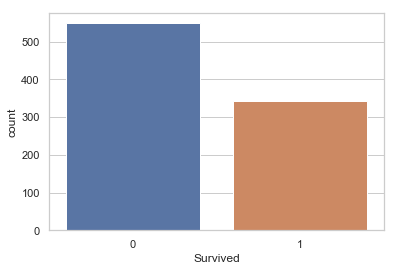

In [14]:
sns.countplot(x = 'Survived', data = data)
plt.show()
# plt.savefig('Count Plot')

In [15]:
survivorsPerc = data.where(data['Survived'] == 1).count()[0] / len(data) * 100
print('Percentage of survivors is', int(survivorsPerc))
print('Percentage of victims is', 100-int(survivorsPerc))
print('The ratio of survivors to victims is', int(survivorsPerc), ':', 100-int(survivorsPerc))

Percentage of survivors is 38
Percentage of victims is 62
The ratio of survivors to victims is 38 : 62


Observations: 
Classes are slightly inbalanced

In [16]:
data.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.147541,0.136612,0.085610,0.777778
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.681287,0.271930,0.087719,0.634503


In [17]:
data.groupby('Survived').count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
Survived,,,,,,,,,,,,,
0,549,549,549,424,549,549,549,549,549,549,549,549,549
1,342,342,342,290,342,342,342,342,340,342,342,342,342


### Observations: 
1. Ticket class (Pclass) of survived is higher than vistims' class
2. Survivors' tickets were much more expensive than vistims' (Fare)
3. There is no substantial difference between the age of survivors and victims
4. Women had more chance to survive than men
5. classes are inballanced



In [18]:
data.groupby('SibSp').count()

,Survived,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
SibSp,,,,,,,,,,,,,
0,608,608,608,608,471,608,608,608,606,608,608,608,608
1,209,209,209,209,183,209,209,209,209,209,209,209,209
2,28,28,28,28,25,28,28,28,28,28,28,28,28
3,16,16,16,16,12,16,16,16,16,16,16,16,16
4,18,18,18,18,18,18,18,18,18,18,18,18,18
5,5,5,5,5,5,5,5,5,5,5,5,5,5
8,7,7,7,7,0,7,7,7,7,7,7,7,7


In [19]:
survivors = data.where(data.Survived == 1)
victims = data.where(data.Survived == 0)
#survivors.count()

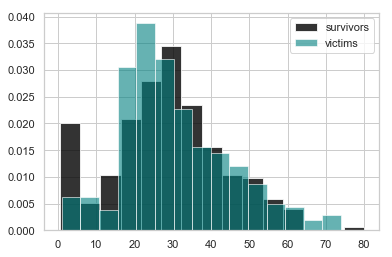

In [20]:
plt.figure(1)

survivors.Age.hist(bins = 15, color = 'black', density = True, alpha = 0.8)  
# density: normalization to form probability density, pdf
victims.Age.hist(bins = 15, color='teal', alpha = 0.6, density = True)  # alpha = transperancy
plt.legend(['survivors', 'victims'])


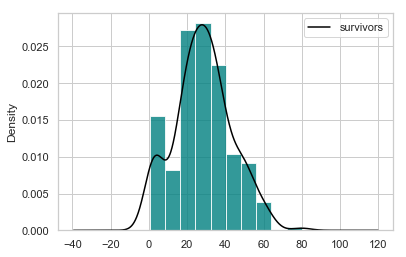

In [21]:
plt.figure(2)

survivors.Age.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
survivors.Age.plot(kind='density', color='black')
plt.legend(['survivors'])

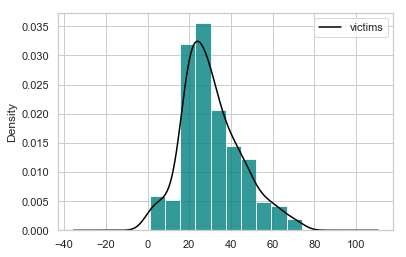

In [22]:
plt.figure(3)

victims.Age.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
victims.Age.plot(kind='density', color='black')
plt.legend(['victims'])

### Preprocessing

#### Oversampling for balancing classes - creating synthetic observations

In [23]:
data2 = data.copy()

# Filling missing data
data2.fillna(data2.Age.median(),inplace = True)
#traindata.fillna(traindata.Embarked_num.mode(),inplace = True)

data2.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Sex_num        0
Cherbourg      0
Queenstown     0
Southampton    0
dtype: int64

In [24]:
corrs = data2.corr()
corrs

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
Survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,0.543351,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,-0.131900,-0.243292,0.221009,0.081720
Age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,-0.081163,0.030248,-0.031415,-0.014665
SibSp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,0.114631,-0.059528,-0.026354,0.070941
Parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,0.245489,-0.011069,-0.081228,0.063036
Fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,0.182333,0.269335,-0.117216,-0.166603
Sex_num,0.543351,-0.131900,-0.081163,0.114631,0.245489,0.182333,1.000000,0.082853,0.074115,-0.125722
Cherbourg,0.168240,-0.243292,0.030248,-0.059528,-0.011069,0.269335,0.082853,1.000000,-0.148258,-0.778359
Queenstown,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,0.074115,-0.148258,1.000000,-0.496624
Southampton,-0.155660,0.081720,-0.014665,0.070941,0.063036,-0.166603,-0.125722,-0.778359,-0.496624,1.000000


# Prediction Models

In [162]:
# Hyperparameters 
test_size = 0.2

### Model 1 - Multivariate Linear Logistic Regression

#### Since there is a high collinearity between a Fare and a class ("Pclass"), we will include only the fare in the model. 

In [163]:
X = data2.loc[:, ['Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Cherbourg', 'Queenstown', 'Southampton']]
y = data2.loc[:, data2.columns == 'Survived']

In [164]:
X.head()

,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,
1,22.0,1,0,7.2500,0,0.0,0.0,1.0
2,38.0,1,0,71.2833,1,1.0,0.0,0.0
3,26.0,0,0,7.9250,1,0.0,0.0,1.0
4,35.0,1,0,53.1000,1,0.0,0.0,1.0
5,35.0,0,0,8.0500,0,0.0,0.0,1.0


#### Cross-validation

In [165]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 100)

#### Model the data

In [166]:
model = LogisticRegression().fit(x_train,y_train)
y_predicted = model.predict(x_test)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Model's Parameters

In [167]:
model.coef_

array([[-0.0222642 , -0.35157276, -0.24407122,  0.01462802,  2.52912134,
         0.09258188, -0.61307576, -0.41240285]])

In [168]:
y_predicted = model.predict(x_test)
y_predicted.shape

(179,)

### Measuring Model Performance

##### Accuracy (correct predictions / total number of data points), Confusion Matrix, Precision & Recall

Total number of observations =  179
Accuracy =  0.79

TP = 52 
TN = 90 
FP = 14 
FN = 23

Precision = 0.79 
Recall = 0.69


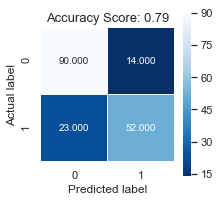

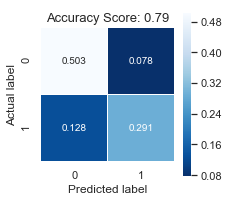

In [228]:
# Measuring Model Performance
[acc, confusion_mat] = accuracy_confusion_mat(model, x_test, y_test, y_predicted)
confusion_plt(confusion_mat, acc)
confusion_perc_plt(confusion_matrix, acc_score)
[TP, TN, FP, FN] = errors(confusion_mat)
precision, recall = precision_recall(TP, TN, FP, FN)

### Model 2 - all numerical features for Logistic Regression

In [229]:
data2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0.0,0.0,1.0


In [230]:
X = data2.loc[:, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Cherbourg', 'Queenstown', 'Southampton']]
y = data2.loc[:, data2.columns == 'Survived']

In [231]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 100)
model = LogisticRegression().fit(x_train,y_train)
y_predicted = model.predict(x_test)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [232]:
y_predicted = model.predict(x_test)

##### Model's Evaluation

Total number of observations =  179
Accuracy =  0.8

TP = 53 
TN = 91 
FP = 13 
FN = 22

Precision = 0.8 
Recall = 0.71


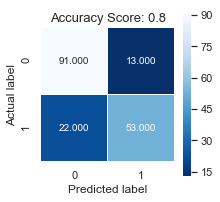

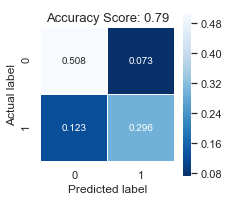

In [233]:
# Measuring Model Performance
[acc, confusion_mat] = accuracy_confusion_mat(model, x_test, y_test, y_predicted)
confusion_plt(confusion_mat, acc)
confusion_perc_plt(confusion_matrix, acc_score)
[TP, TN, FP, FN] = errors(confusion_mat)
precision, recall = precision_recall(TP, TN, FP, FN)

### Model 3 - Decision Tree Classifier

#### Decision tree training

In [247]:
model_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth = 3, min_samples_leaf = 5).fit(x_train, y_train)

In [248]:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [249]:
x_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,
206,3,2.0,0,1,10.4625,1,0.0,0.0,1.0
45,3,19.0,0,0,7.8792,1,0.0,1.0,0.0
822,3,27.0,0,0,8.6625,0,0.0,0.0,1.0
459,2,50.0,0,0,10.5000,1,0.0,0.0,1.0
796,2,39.0,0,0,13.0000,0,0.0,0.0,1.0


In [250]:
x_test.iloc[0]['Pclass':'Age']

Pclass    3.0
Age       2.0
Name: 206, dtype: float64

In [251]:
x_test.iloc[0]['Pclass':'Southampton']

Pclass          3.0000
Age             2.0000
SibSp           0.0000
Parch           1.0000
Fare           10.4625
Sex_num         1.0000
Cherbourg       0.0000
Queenstown      0.0000
Southampton     1.0000
Name: 206, dtype: float64

In [252]:
y_predicted = model_tree.predict(x_test)
#y_predicted

#### Model's Evaluation

Total number of observations =  179
Accuracy =  0.81

TP = 54 
TN = 91 
FP = 13 
FN = 21

Precision = 0.81 
Recall = 0.72


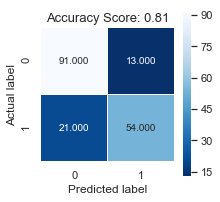

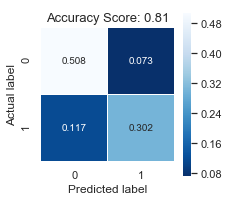

In [279]:
# Measuring Model Performance
[acc, confusion_mat] = accuracy_confusion_mat(model_tree, x_test, y_test, y_predicted)
confusion_plt(confusion_mat, acc)
confusion_perc_plt(confusion_matrix, acc_score)
[TP, TN, FP, FN] = errors(confusion_mat)
precision, recall = precision_recall(TP, TN, FP, FN)